In [1]:
import torch
from models import VisionTransformer, CONFIGS, AutoEncoder, ResNet50, InputEmbed
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
# from dataset import get_dataloader
from dataset import make_word_img, get_img, get_color
import csv
import pandas as pd
from tqdm import tqdm
import gensim
from visualization import visualize,get_word_img,get_visualization_res
from sklearn.metrics import confusion_matrix
import seaborn as sns
import shutil
import cv2
from PIL import Image
import pickle

In [2]:
torch.cuda.is_available()

True

In [3]:
MODEL = 'Transformer'
NUM_EPOCHS = 1000
BATCH_SIZE = 64
DEVICE = 'cuda'
EARLY_STOP = True
NUM_LAYER = 4
EARLY_STOP_NUM = 10
MODEL_SIZE = f"head6_layer{NUM_LAYER}"
MODEL_NAME = '1' #ResNet50
LR = 1e-5
SAVE_ROOT = "results_for_wo_one_element"
SAVE_FOLDAR = f'{MODEL}_{MODEL_SIZE}_lr{LR}'
DROP_ELEMENTS = ["font_style","char_color","bk_color","height","coord"]
ELEMENTS = ["semantic","font_style","char_color","bk_color","height","coord"]
ttf_path = "/workspace/dataset/OpenSans-Regular.ttf"


for dp_elemet in DROP_ELEMENTS:
    ELEMENTS.remove(dp_elemet)
    SAVE_FOLDAR += f'_{dp_elemet}'
CONFIGS["title_level_config"]["transformer"]["num_layers"] = NUM_LAYER
def torch_fix_seed(seed=0):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorchsemantic
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True
torch_fix_seed(0)

In [4]:
title_level_config = CONFIGS["title_level_config"]
word_level_config = CONFIGS["word_level_config"]
model_title_level = VisionTransformer(title_level_config, num_classes=32, zero_head=False, vis=True).to(DEVICE)
model_word_level = VisionTransformer(word_level_config, num_classes=32, zero_head=False, vis=True).to(DEVICE)
model_word_level.head = nn.Identity()
model_word_level.fc = nn.Identity()

semantic_model_path = '/workspace/dataset/GoogleNews-vectors-negative300.bin.gz'
model_semantic = gensim.models.KeyedVectors.load_word2vec_format(semantic_model_path, binary=True)


embed_xy = InputEmbed(input_size=2,output_size=300).to(DEVICE)
embed_size = InputEmbed(input_size=1,output_size=300).to(DEVICE)

model_path = f'/workspace/{SAVE_ROOT}/{SAVE_FOLDAR}/best_model_word_level.pth'
model_word_level.load_state_dict(torch.load(model_path,map_location=DEVICE))

model_path = f'/workspace/{SAVE_ROOT}/{SAVE_FOLDAR}/best_model_title_level.pth'
model_title_level.load_state_dict(torch.load(model_path,map_location=DEVICE))


model_font = ResNet50(class_num=2094,feat_dim=300).to(DEVICE)
font_model_path = "/workspace/results/ResNet50_sw128_h64_lr0.001_v3/best_model.pth"
model_font.load_state_dict(torch.load(font_model_path,map_location=DEVICE))

model_path = f'/workspace/{SAVE_ROOT}/{SAVE_FOLDAR}/best_model_coord.pth'
embed_xy.load_state_dict(torch.load(model_path,map_location=DEVICE))

model_path = f'/workspace/{SAVE_ROOT}/{SAVE_FOLDAR}/best_model_size.pth'
embed_size.load_state_dict(torch.load(model_path,map_location=DEVICE))

<All keys matched successfully>

# attention vis. (title level)

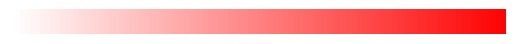

In [5]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
color = [[(255,255-int(255*0.01*i),255-int(255*0.01*i)) for i in range(100)] for j in range(5)]
color = np.array(color)
fig, ax = plt.subplots()
ax.imshow(color)
ax.set_axis_off()

In [6]:
df_test = pd.read_csv(f"/workspace/dataset/AmazonBookCoverImages/test.csv")
df_test = df_test[df_test['split']=='test'].reset_index(drop=True)
df_test = df_test[df_test['hight']>14]
df_test = df_test[df_test['width']>14]
df_test_org = pd.read_csv(f'/workspace/dataset/book30-listing-test.csv'\
                 ,encoding='cp932',names=("Amazon ID (ASIN)","Filename","Image URL","Title","Author","Category ID","Category"))
df_test = pd.merge(df_test_org,df_test,on="Filename")

In [7]:
category_list = df_test["Category"].unique()

In [ ]:
torch_fix_seed(seed=0)
token_num = 16


CONFIGS["title_level_config"]["transformer"]["num_layers"] = NUM_LAYER
title_level_config = CONFIGS["title_level_config"]
model_semantic_only = VisionTransformer(title_level_config, num_classes=32, zero_head=False, vis=True).to(DEVICE)
model_path = '/workspace/results_for_multimodal_20230627/SemanticOnly_head6_layer4_lr1e-05_v1/best_model_semantic_only.pth'
model_semantic_only.load_state_dict(torch.load(model_path,map_location=DEVICE))

model_word_level.eval()
model_title_level.eval()
model_font.eval()
model_semantic_only.eval()
embed_size.eval() 
embed_xy.eval()   
df_res =  df_test[['folder','Title','Category','Category ID']].copy()
df_res = df_res[~df_res.duplicated()].reset_index(drop=True)

for i in range(30):
    #torch.argmax(y,1).item()
    k = str(i+1)
    col = f'top{k}_res'
    df_res[col] = 100
                
for category in tqdm(category_list):
    book_foldar_list = df_res[df_res['Category']==category]['folder'].values
    label_list = []
    all_vec_list = []
    all_title_list = []
    zero_vec = torch.zeros((len(ELEMENTS),300)).to(DEVICE)
    attn_dict = {'foldar':[],'title':[],'elements':[],'word':[]}
    with torch.no_grad():
        for book_foldar in book_foldar_list:
            word_vec_list = []
            vec_list = []
            word_list = ''
            df_tmp = df_test[df_test['folder']==book_foldar].reset_index(drop=True)
            label = df_tmp.loc[0,'Category ID']
            category = df_tmp.loc[0,'Category']
            filename = df_tmp.loc[0,'Filename']
            foldar = book_foldar
            for j in range(token_num): 
                if len(df_tmp)>j: 
                    word = df_tmp['word'].values[j]
                    word_list += word
                    w2v = model_semantic[word]
                    semantic_vec = (torch.from_numpy(w2v.astype(np.float32)).clone()).to(DEVICE)
                    w2v_torch = (torch.from_numpy(w2v.astype(np.float32)).clone()).to(DEVICE)
                    word_vec_list.append(w2v_torch)
                    # フォントの取得
                    img_name = df_tmp['img_name'].values[j]
                    img_path = '/workspace/dataset/word_detection_from_bookCover/dataset/'+category+'/word/' + foldar + '/'+ img_name
                    if not os.path.isfile(img_path):
                        img_path = '/workspace/dataset/CannotRead/word/' + foldar + '/'+ img_name
                    img = get_img(img_path) 
                    _, font_vec = model_font(img.to(DEVICE))
                    font_vec = font_vec.reshape(-1).detach()
                    # 色の取得
                    ch_color, bk_color = get_color(img_path)

                    # 高さの取得
                    height = torch.tensor([df_tmp.loc[j,"hight"]/df_tmp.loc[j,"book_cover_hight"]])
                    x_height = embed_size(height.to(DEVICE,torch.float32))

                    # 座標の取得
                    coord = torch.tensor([df_tmp.loc[j,"coord_x"]/df_tmp.loc[j,"book_cover_width"],df_tmp.loc[j,"coord_y"]/df_tmp.loc[j,"book_cover_hight"]])
                    x_coord = embed_xy(coord.to(DEVICE,torch.float32))
                    
                    data_list = []
                    used_elements = []
                    if "semantic" in ELEMENTS:
                        data_list.append(semantic_vec)
                        used_elements.append("semantic")
                    if "font_style" in ELEMENTS:
                        data_list.append(font_vec)
                        used_elements.append("font_style")
                    if "char_color" in ELEMENTS:
                        data_list.append(ch_color.to(DEVICE))
                        used_elements.append("char_color")
                    if "bk_color" in ELEMENTS:
                        data_list.append(bk_color.to(DEVICE))
                        used_elements.append("bk_color")
                    if "height" in ELEMENTS:
                        data_list.append(x_height)
                        used_elements.append("height")
                    if "coord" in ELEMENTS:
                        data_list.append(x_coord)
                        used_elements.append("coord")
                    feat_vec = torch.stack(data_list)
                    vec_list.append(feat_vec)
                    word_list += ' '
                    assert used_elements == ELEMENTS, "not match between used feat. and selected feat."
                    
                else: #ない場合はゼロベクトルを入れる
                    word_vec_list.append(torch.zeros((300)).to(DEVICE))
                    vec_list.append(zero_vec)
                    word_list += '* '
            vec_list = torch.stack(vec_list)
            word_vec_list = torch.stack(word_vec_list)
            x_word,_ = model_word_level(vec_list) 
            y,_ = model_title_level(x_word.reshape(1,16,300))
            for i in range(30):
                topk_res = torch.argsort(y,descending=True)[0,i].item()
                #torch.argmax(y,1).item()
                k = str(i+1)
                col = f'top{k}_res'
                df_res.loc[df_res['folder']==foldar,col] = int(topk_res)
            attn,logits = visualize(x_word.reshape(1,16,300),model_title_level.to(DEVICE),device=DEVICE)
            attn_element,logits_element = visualize(vec_list.reshape(16,len(ELEMENTS),300),model_word_level.to(DEVICE),device=DEVICE)
            mask_semantic,_ = visualize(word_vec_list.reshape(1,16,300),model_semantic_only.to(DEVICE),device=DEVICE)

            img_all = 0
            idx = 0
            words = word_list.split(' ')
            for i in range(len(words)):
                word = words[i]
                if word == '':
                    break
                else:
                    rate = attn[:,i].item()
                    rate_design = attn_element[i,:].cpu().tolist()
                    rate_semantic = mask_semantic[:,i].item()
                    img = get_visualization_res(word,rate,rate_design,width=180,height=120,element_num=len(ELEMENTS))
                    w,h,_ = img.shape
                    img_semantic = get_word_img(word,rate_semantic,width=h,height=w,ttf=ttf_path)
                    if i == 0:  
                        img_all = img
                        img_semantic_all = img_semantic
                    else:
                        img_all = np.hstack((img_all,img))
                        img_semantic_all = np.hstack((img_semantic_all,img_semantic))

            img_all = np.vstack((img_semantic_all,img_all))
            book_id = foldar.split("res_")[-1]
            book_path =  f'/workspace/dataset/AmazonBookCoverImages/genres/{category}/{book_id}.jpg'
            detect_book_path =  f'/workspace/dataset/word_detection_from_bookCover/dataset/{category}/ditection/{book_foldar}.jpg'
            if not os.path.isfile(book_path):
                book_path = f'/workspace/dataset/AmazonBookCoverImages/CannotRead/{book_id}.jpg'
                detect_book_path = f'/workspace/dataset/CannotRead/ditection/{book_foldar}.jpg'
            os.makedirs(f'/workspace/{SAVE_ROOT}/bookcover/{category}/',exist_ok=True)
            save_book_path = f'/workspace/{SAVE_ROOT}/bookcover/{category}/{book_foldar}.png'
            shutil.copy(book_path, save_book_path)
            os.makedirs(f'/workspace/{SAVE_ROOT}/detect_bookcover/{category}/',exist_ok=True)
            save_detect_book_path = f'/workspace/{SAVE_ROOT}/detect_bookcover/{category}/{book_foldar}.png'
            shutil.copy(detect_book_path, save_detect_book_path)

            attn_dict['foldar'].append(foldar)
            attn_dict['elements'].append(attn_element)
            attn_dict['word'].append(attn)
            attn_dict['title'].append(words)
            os.makedirs(f'/workspace/{SAVE_ROOT}/visualization_res/{SAVE_FOLDAR}/{category}/',exist_ok=True)
            img_all = cv2.cvtColor(img_all, cv2.COLOR_BGR2RGB)
            cv2.imwrite(f'/workspace/{SAVE_ROOT}/visualization_res/{SAVE_FOLDAR}/{category}/{book_foldar}.png', img_all)
        
        os.makedirs(f'/workspace/{SAVE_ROOT}/attention/{SAVE_FOLDAR}/',exist_ok=True)
        with open(f'/workspace/{SAVE_ROOT}/attention/{SAVE_FOLDAR}/{category}.pickle',"wb") as f:
            pickle.dump(attn_dict,f)
shutil.make_archive(f'/workspace/{SAVE_ROOT}/visualization_res', 'zip', root_dir=f'/workspace/{SAVE_ROOT}/visualization_res')
shutil.make_archive(f'/workspace/{SAVE_ROOT}/bookcover', 'zip', root_dir=f'/workspace/{SAVE_ROOT}/bookcover')
name = ""
for i in range(len(DROP_ELEMENTS)):
    name += DROP_ELEMENTS[i]
os.makedirs(f'/workspace/{SAVE_ROOT}/csv/',exist_ok=True)
# df_res.to_csv(f'/workspace/{SAVE_ROOT}/csv/{name}_res.csv')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [11:22<00:00, 22.74s/it]


In [ ]:
k = 5
for k in [3,5]:
    correct_num = 0
    for i in range(len(df_res)):
        pred_list = [df_res.loc[i,f"top{j}_res"] for j in range(1,k+1)]
        true_label = df_res.loc[i,"Category ID"]
        if true_label in pred_list:
            correct_num += 1
    print(correct_num/len(df_res))

In [ ]:
# df_res.to_csv('/workspace/{SAVE_ROOT}/all_res.csv')

In [ ]:
for i in range(30):
    category = df_res[df_res["Category ID"]==i]['Category'].values[0]
    total_num = len(df_res[df_res["Category ID"]==i]['Category'])
    true_num = len(df_res[(df_res["Category ID"]==i) & (df_res["Category ID"]==df_res["top1_res"])])
    acc = round(true_num/total_num*100,4)
    print(category, f'{true_num}/{total_num}:', acc)

In [ ]:
df_tmp = df_res[["Category ID","Category"]]
df_tmp = df_tmp[~df_tmp.duplicated()]

In [ ]:
y_true = df_res["Category ID"].values
y_pred = df_res["top1_res"].values
cm = confusion_matrix(y_true, y_pred)
xtics = df_tmp.sort_values("Category ID")['Category'].values
plt.figure(figsize = (14,10))
plt.rcParams["font.size"] = 14
sns.heatmap(cm, cmap='Blues',xticklabels=xtics,yticklabels=xtics)#,annot=True
plt.show()